In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [13]:
stock = 'GOOG'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [14]:
globals()[stock] = yf.download(stock, start, end)
df_goog = globals()[stock]

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning

In [15]:
df_goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,120.136002,120.985001,119.224998,119.758499,119.758499,33788000
2021-05-04,118.487000,118.962997,115.584999,117.712502,117.712502,35120000
2021-05-05,118.420998,119.110001,117.570503,117.836998,117.836998,21806000
2021-05-06,117.531998,119.135498,117.116898,119.067497,119.067497,20618000
2021-05-07,120.000000,120.820503,119.500000,119.934502,119.934502,23272000


In [16]:
df_goog.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,175.990005,176.419998,171.399994,173.690002,173.690002,56500800
2024-04-29,170.770004,171.380005,167.059998,167.899994,167.899994,35914600
2024-04-30,167.380005,169.869995,164.500000,164.639999,164.639999,29420800
2024-05-01,166.179993,168.809998,164.899994,165.570007,165.570007,25223200
2024-05-02,166.669998,168.529999,165.690002,168.460007,168.460007,17016900


In [17]:
df_goog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2021-05-03 to 2024-05-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


In [18]:
df_goog.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Analysis

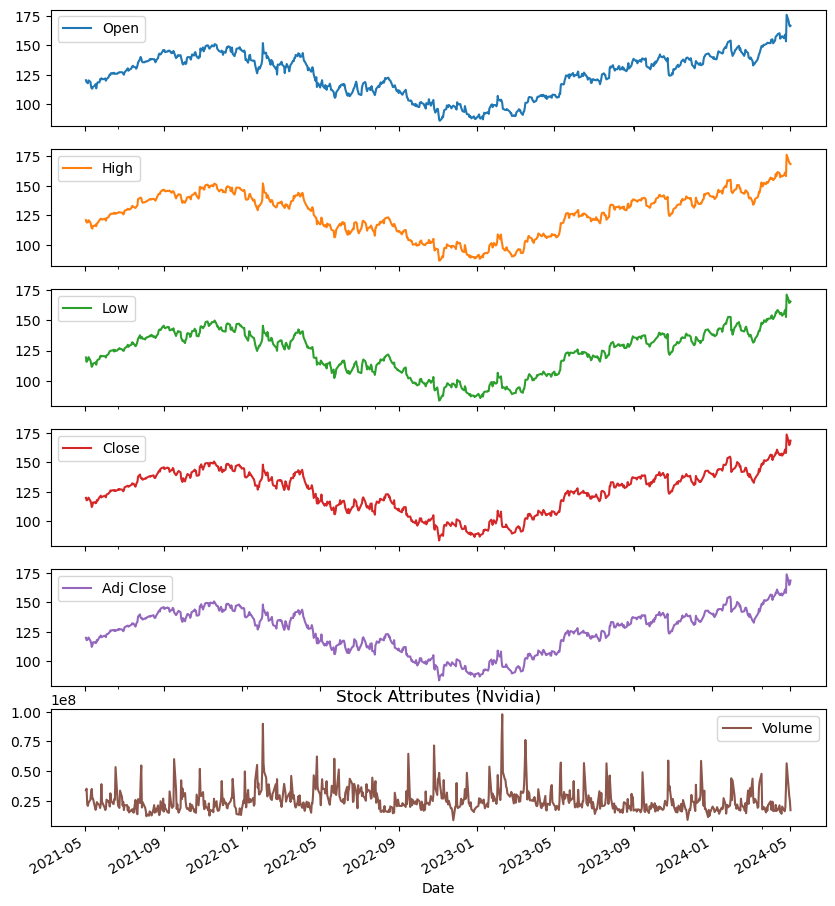

In [19]:
df_goog.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [20]:
fig = px.line(df_goog, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

In [21]:
fig = px.line(df_goog, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [22]:
# Nvidia Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_goog.index, open=df_goog['Open'], high=df_goog['High'], low=df_goog['Low'], close=df_goog['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

## Calculation of MA

Text(0.5, 1.0, 'Tesla Moving Averages')

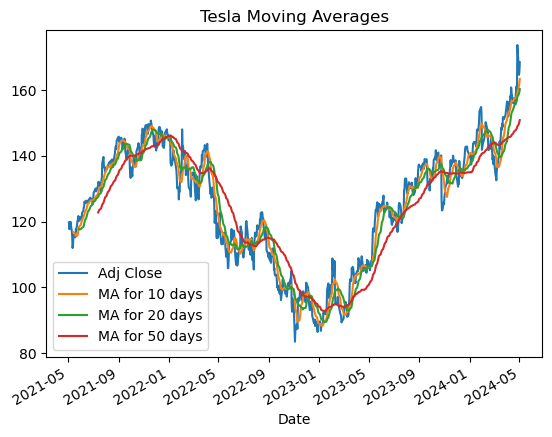

In [23]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_goog[column_name] = df_goog['Adj Close'].rolling(ma).mean()

df_goog[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Google Moving Averages")

Text(0.5, 1.0, 'Tesla Daily Return')

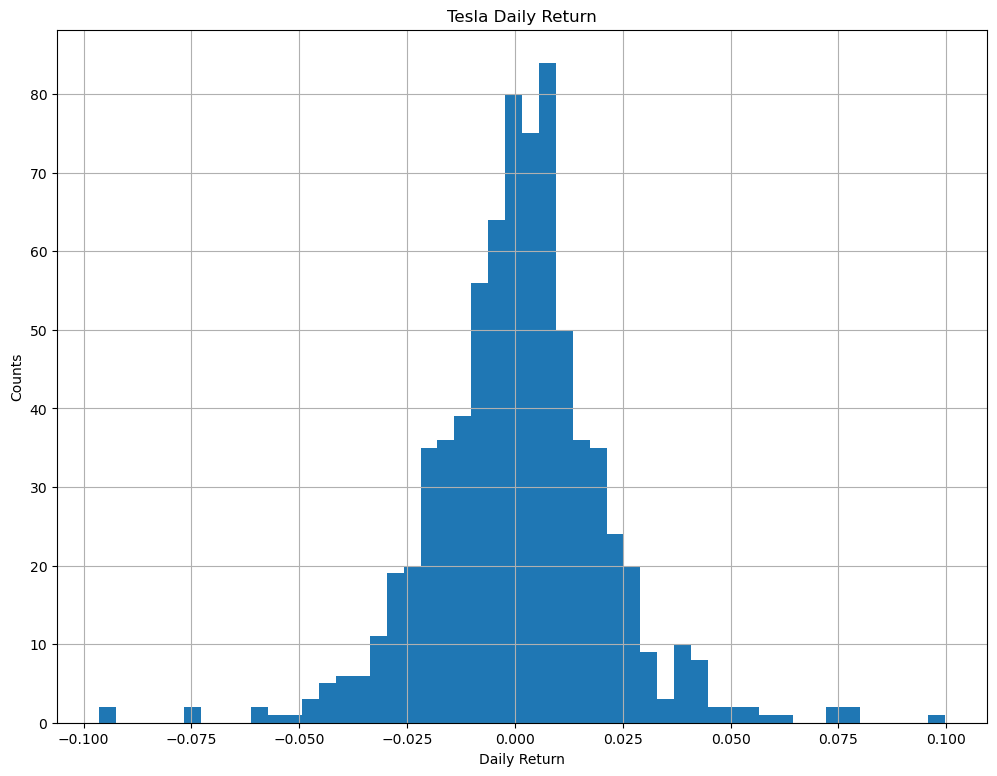

In [24]:
df_goog['Daily Return'] = df_goog['Adj Close'].pct_change()

plt.figure(figsize=(12,9))

df_goog['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Google Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis, forming a unimodal distribution. Increasing and decreasing approximately 5%.

## Risk

In [25]:
closing_df = pdr.get_data_yahoo(stock, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  1 of 1 completed


Text(50, 50, 'GOOG')

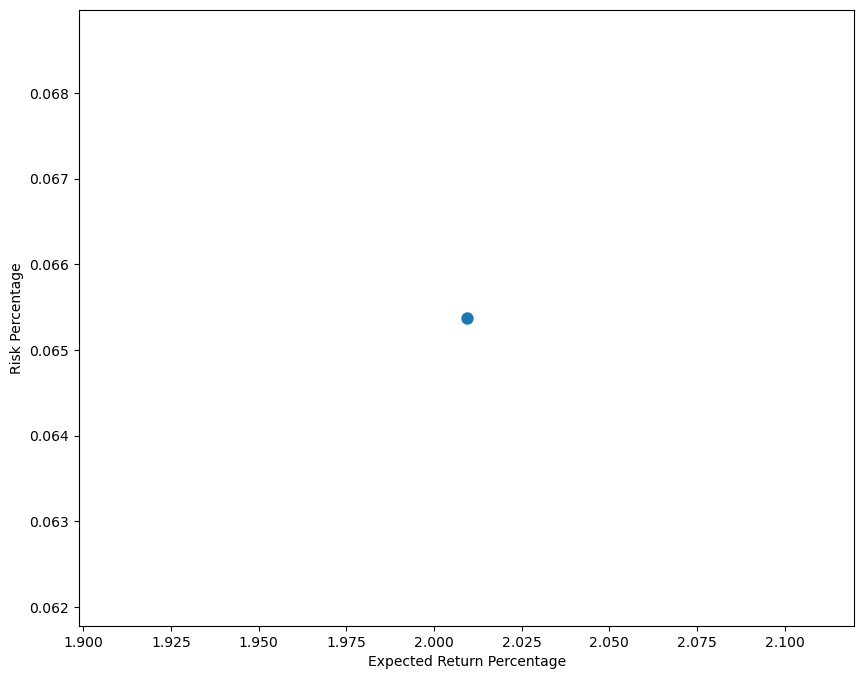

In [26]:
rets = tech_rets.dropna()

area = np.pi * 20

return_lvl = rets.mean()
return_lvl = return_lvl * 100

risk = rets.std()
risk = risk * 100

plt.figure(figsize=(10,8))
plt.scatter(risk, return_lvl, s=area)
plt.xlabel('Expected Return Percentage')
plt.ylabel('Risk Percentage')

plt.annotate(stock, xy=(rets.mean(), rets.std()), xytext=(50,50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue'))

## Prediction Model

In [27]:
start = datetime(end.year - 5, end.month, end.day)
df_goog = pdr.get_data_yahoo('GOOG', start=start, end=end)

df_goog.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-03,58.682499,59.340000,58.450001,59.270000,59.270000,39614000
2019-05-06,58.313000,59.542500,58.313000,59.469501,59.469501,31278000
2019-05-07,59.023499,59.521999,58.051998,58.705002,58.705002,31028000
2019-05-08,58.600498,59.021198,58.286999,58.313499,58.313499,26186000
2019-05-09,57.951500,58.483002,57.542500,58.118999,58.118999,23714000


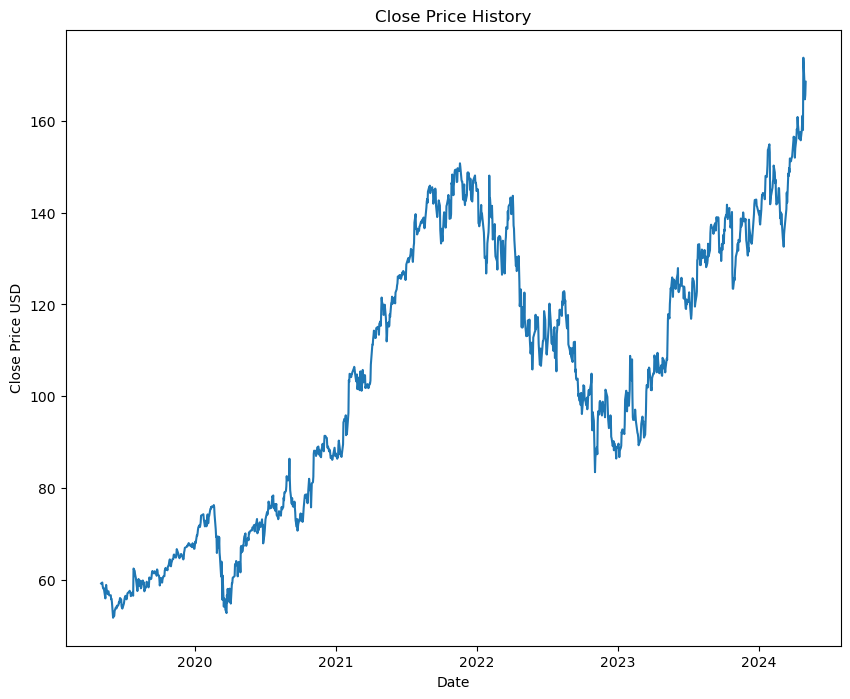

In [28]:
plt.figure(figsize=(10,8))
plt.title('Close Price History')
plt.plot(df_goog['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [29]:
window_size = 60

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [30]:
X = df_goog[['High', 'Low', 'Open']]  # Features
y = df_goog['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_goog.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
30/30 [==============================] - 2s 26ms/step - loss: 0.0800 - val_loss: 0.0036
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
30/30 [==============================] - 1s 18ms/step - loss: 9.9073e-04 - val_loss: 0.0011
Epoch 8/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 8.9220e-04 - val_loss: 9.8628e-04
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 7.9873e-04 - 

In [31]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 5ms/step


In [32]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
loss = model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared (R2) Score:', r2)

8/8 [==============================] - 0s 6ms/step - loss: 4.8152e-04
Test Loss: 0.0004815245047211647
Mean Squared Error: 0.00048152462858636985
Root Mean Squared Error: 0.021943669442150506
R-squared (R2) Score: 0.9914824557578918


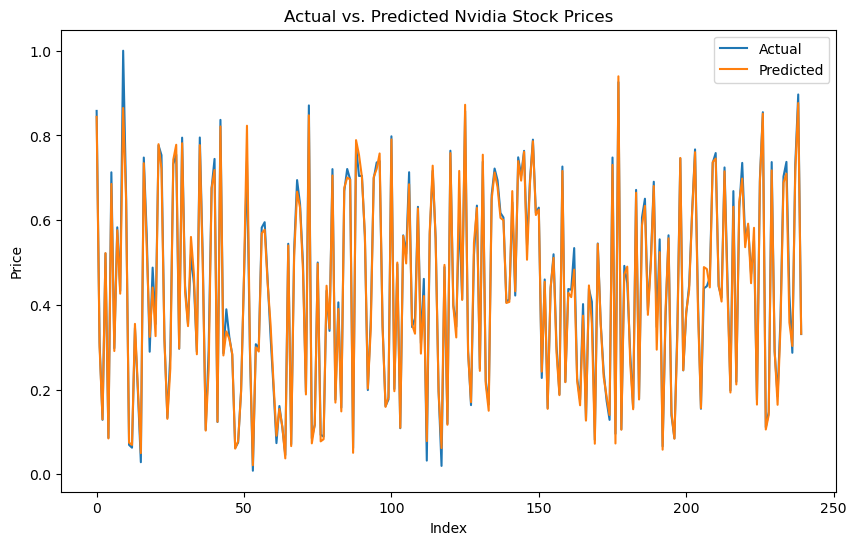

In [33]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [34]:
# creating a new dataset to analyze within 60 days
test_data = scaled_prices[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

2/2 [==============================] - 0s 6ms/step


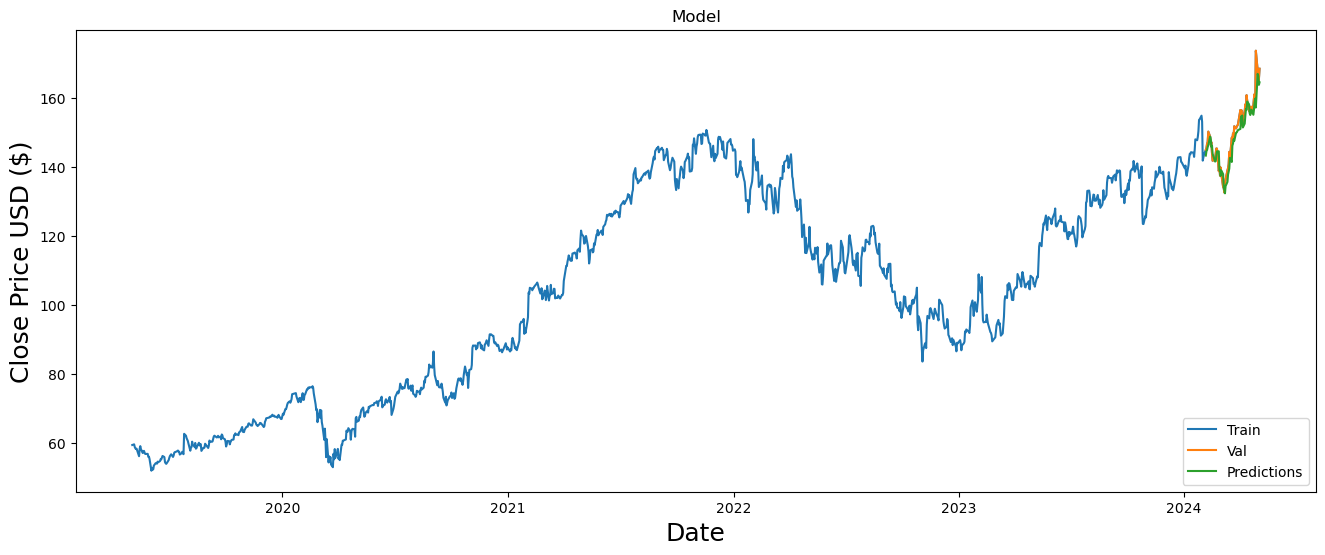

In [35]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_goog['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

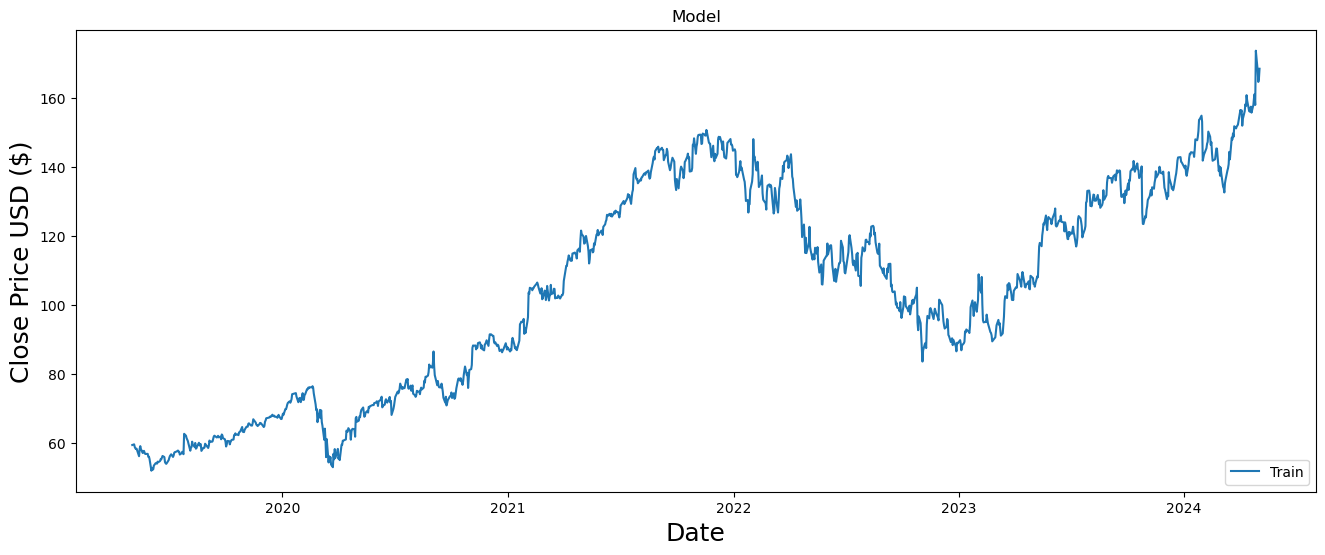

In [36]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_goog['Close'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [37]:
valid

,Close,Predictions
Date,,
2024-02-05,144.929993,143.263062
2024-02-06,145.410004,144.562775
2024-02-07,146.679993,144.876465
2024-02-08,147.220001,145.732452
2024-02-09,150.220001,146.254578
...,...,...
2024-04-26,173.690002,157.210922
2024-04-29,167.899994,166.957214
2024-04-30,164.639999,166.327332


## Prediction

In [38]:
last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_value = model.predict(x_predict)

predicted_decimal = scaler.inverse_transform(predicted_value)

print("Predicted Decimal Value for the Next Day:", predicted_decimal[0][0])

1/1 [==============================] - 0s 17ms/step
Predicted Decimal Value for the Next Day: 167.30452


In [39]:
future_days = 5

last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    # Predict the next day
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    # Store the predicted value
    predicted_values.append(predicted_decimal[0][0])
    
    # Shift the input data by one day for the next prediction
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value  # Replace the last value with the predicted value

print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 16ms/step
Predicted Decimal Values for the Next 5 Days: [167.30452, 166.61444, 165.6581, 164.75676, 163.9269]
